## Experiment1: Time series prediction 

Time series forecasting is an important area of machine learning. t is important because there are so many prediction problems that involve a time component. 
In this notebook we will apply different sequence prediciton techniques to predict the output based on previous days, months or years data.




## 1.  Load Time Series Data

This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.

The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. The complete feature list in the raw data is as follows:

1. No: row number
2. year: year of data in this row
3. month: month of data in this row
4. day: day of data in this row
5. hour: hour of data in this row
6. pm2.5: PM2.5 concentration
7. DEWP: Dew Point
8. TEMP: Temperature
9. PRES: Pressure
10. cbwd: Combined wind direction
11. Iws: Cumulated wind speed
12. Is: Cumulated hours of snow
13. Ir: Cumulated hours of rain

We can use this data and frame a forecasting problem where, given the weather conditions and pollution for prior hours, we forecast the pollution at the next hour.

This dataset can be used to frame other forecasting problems.

You can download the dataset from the UCI Machine Learning Repository.

 [Beijing PM2.5 Data Data Set](https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data)

## 2. Data Preprocessing
The data is not ready to use. We must prepare it first.

Below are the first few rows of the raw dataset.

In [ ]:
from pandas import read_csv
from datetime import datetime
dataset = read_csv('Train_Kaggle.csv')
dataset


- The first step is to consolidate the date-time information into a single date-time so that we can use it as an index in Pandas.

- A quick check reveals NA values for pm2.5 for the first 24 hours. We will, therefore, need to remove the first row of data. There are also a few scattered “NA” values later in the dataset; we can mark them with 0 values for now.

- The script below loads the raw dataset and parses the date-time information as the Pandas DataFrame index. The “No” column is dropped and then clearer names are specified for each column. Finally, the NA values are replaced with “0” values and the first 24 hours are removed.

- The “No” column is dropped and then clearer names are specified for each column. Finally, the NA values are replaced with “0” values and the first 24 hours are removed.

In [2]:
from datetime import datetime
# load data

def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv('PRSA_data_2010.1.1-2014.12.31.csv', 
                   parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)

dataset.drop('No', axis=1, inplace=True)

# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)

# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


## 3. Data Visualization
we can create a quick plot of each series and see what we have.

The code below loads the new “pollution.csv” file and plots each series as a separate subplot, except wind speed dir, which is categorical.

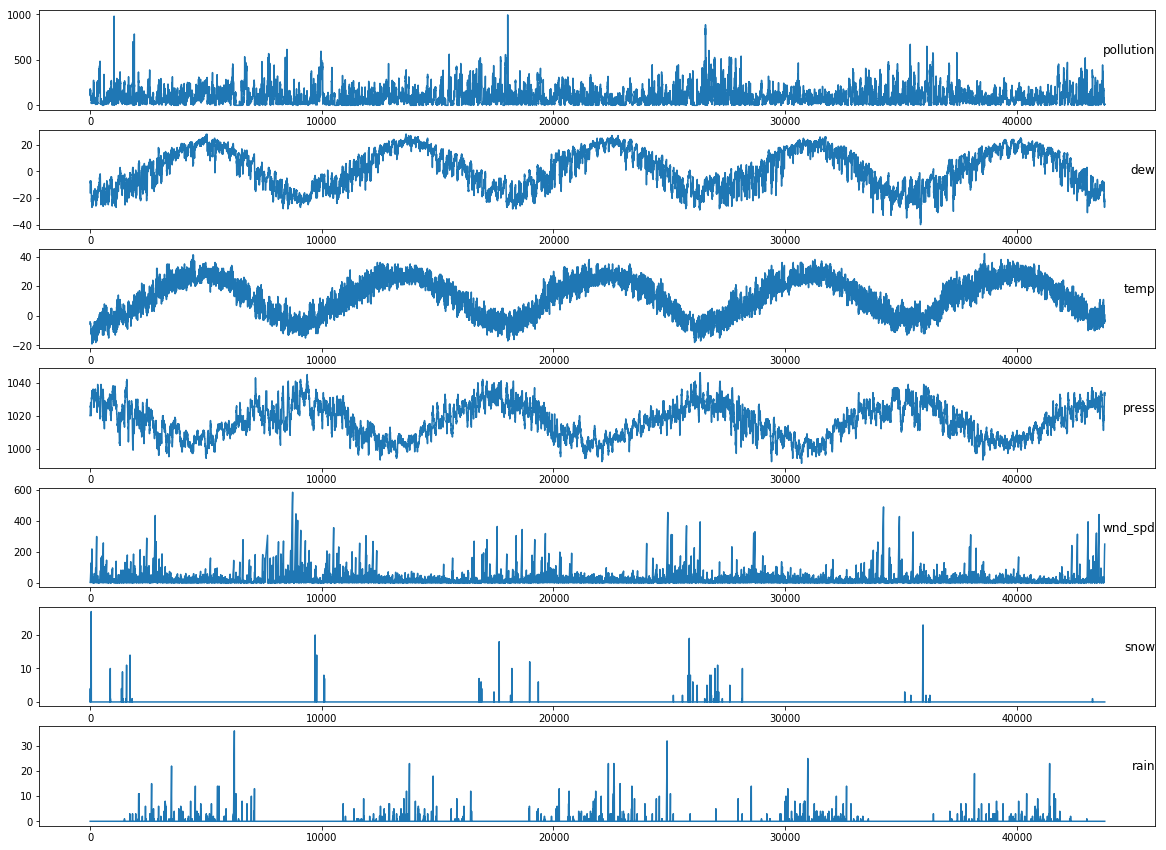

In [17]:
from pandas import read_csv
import matplotlib.pyplot as plt

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# specify columns to plot , skip 4 becoz it is categorical
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(20,15))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

## 4. Preparing Data for Time Series Prediction

- The first step is to prepare the pollution dataset for the Time Series problem.

- This involves framing the dataset as a supervised learning problem and normalizing the input variables.

- We will frame the supervised learning problem as predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step. So, the input is features at time step(t-1) and output is pollution at time t. 

- We can transform the dataset using the series_to_supervised() function given in code



- Steps to convert the  Time Series to a Supervised Learning Problem are:
    
    1. Load the “pollution.csv” dataset 
    2. Label encoded (integer encoded) the wind speed feature
    3. Normalize the Dataset
    4. Transform the dataset into supervised learning problem by calling tghe function "series_to_supervised"
    
    
    
- Series to supervised function:

    - Intution is in time series forecasting terminology the current time (t) and future times (t+1, t+n) are forecast times and past observations (t-1, t-n) are used to make forecasts.
    - We can see how positive and negative shifts can be used to create a new DataFrame from a time series with sequences of input and output patterns for a supervised learning problem.
    - This permits not only classical X -> y prediction, but also X -> Y where both input and output can be sequences.
    - The function takes four arguments:

        1. data: Sequence of observations as a list or 2D NumPy array. Required.
        2. n_in: Number of lag observations as input (X). Values may be between [1..len(data)] Optional. Defaults to 1.
        3. n_out: Number of observations as output (y). Values may be between [0..len(data)-1]. Optional. Defaults to 1.
        4 . dropnan: Boolean whether or not to drop rows with NaN values. Optional. Defaults to True.

        5. The function returns Pandas DataFrame of series framed for supervised learning.



In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    
    n_vars = data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

In [5]:
# convert series to supervised learning
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import numpy as np
import pandas as pd

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
print(values.shape)

# integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# previous 1 hour features used for framing as supervised learning problem 
## specify the number of lag hours
n_hours1 = 1
n_features1 = 8
reframed1 = series_to_supervised(scaled, n_hours1, 1)
print(reframed1.head())
print("\n")

# previous 3 hour features used for framing as supervised learning problem 
## specify the number of lag hours
n_hours2 = 3
n_features2 = 8
reframed2 = series_to_supervised(scaled, n_hours2, 1)
print(reframed2.head())

(43800, 8)
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
1   0.000000        0.0  0.148893  0.367647  0.245902  0.527273  0.666667   
2   0.000000        0.0  0.159960  0.426471  0.229508  0.545454  0.666667   
3   0.000000        0.0  0.182093  0.485294  0.229508  0.563637  0.666667   
4   0.037037        0.0  0.138833  0.485294  0.229508  0.563637  0.666667   
5   0.074074        0.0  0.109658  0.485294  0.213115  0.563637  0.666667   

    var6(t)   var7(t)  var8(t)  
1  0.003811  0.000000      0.0  
2  0.005332  0.000000      0.0  


## 5. Splitt the Dataset into training and testing data

### Case1: Prediction using prev 1 hour data:
 We will split data into prev 1 year data for training and 4 year of data for testing

In [6]:
# split into train and test sets
values1 = reframed1.values
n_train_hours1 = 4*365 * 24
n_obs1 = n_hours1 * n_features1

train1 = values1[:n_train_hours1, :]
test1 = values1[n_train_hours1:, :]

# split into input and outputs by taking last column "pollution" as target
train_X1, train_y1 = train1[:, :n_obs1], train1[:, -n_features1]
test_X1, test_y1 = test1[:, :n_obs1], test1[:, -n_features1]

# reshape input to be 3D [samples, timesteps, features] because LSTM takes 3d data as input
train_X1 = train_X1.reshape((train_X1.shape[0], 1, train_X1.shape[1]))
test_X1 = test_X1.reshape((test_X1.shape[0], 1, test_X1.shape[1]))
print(train_X1.shape, train_y1.shape, test_X1.shape, test_y1.shape)

(35040, 1, 8) (35040,) (8759, 1, 8) (8759,)


### Case2: Prediction using prev 3 hour data:
 We will split data into prev 1 year data for training and 4 year of data for testing

In [7]:
# split into train and test sets
values2 = reframed2.values
n_train_hours2 = 4 * 365 * 24
n_obs2 = n_hours2 * n_features2
print(n_obs2)
train2 = values2[:n_train_hours2, :]
test2 = values2[n_train_hours2:, :]

# split into input and outputs by taking last column "pollution" as target
train_X2, train_y2 = train2[:, :n_obs2], train2[:, -n_features2]
test_X2, test_y2 = test2[:, :n_obs2], test2[:, -n_features2]

# reshape input to be 3D [samples, timesteps, features] because LSTM takes 3d data as input
train_X2 = train_X2.reshape((train_X2.shape[0], 3, train_X2.shape[1]//3))
test_X2 = test_X2.reshape((test_X2.shape[0], 3, test_X2.shape[1]//3))
print(train_X2.shape, train_y2.shape, test_X2.shape, test_y2.shape)

24
(35040, 3, 8) (35040,) (8757, 3, 8) (8757,)


## 6. Time Series Prediction Techniques

### a) Linear Regression on Lagged Dataset


    


In [8]:
def calc_rmse(ypred, X_regr, y_regr):
    # invert scaling for forecast
    inv_ypred = np.concatenate((ypred, X_regr[:, 1:8]), axis=1)
    inv_ypred = scaler.inverse_transform(inv_ypred)
    inv_ypred = inv_ypred[:,0]

    # invert scaling for actual
    y_regr = y_regr.reshape((len(y_regr), 1))
    inv_y = np.concatenate((y_regr, X_regr[:, 1:8]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_ypred))
    print('RMSE: %.3f' % rmse)
    
    return rmse

### CASE 1

In [9]:
# reshape input to be 2D [samples, timesteps, features] because LR takes 2d data as input
train_X1_regr = train_X1.reshape((train_X1.shape[0],train_X1.shape[2]))
test_X1_regr = test_X1.reshape((test_X1.shape[0], test_X1.shape[2]))

train_y1_regr = train_y1
test_y1_regr = test_y1
print(train_X1_regr.shape, train_y1_regr.shape, test_X1_regr.shape, test_y1_regr.shape)

(35040, 8) (35040,) (8759, 8) (8759,)


In [10]:
import numpy as np
from sklearn import linear_model
from math import sqrt
from sklearn.metrics import mean_squared_error

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(train_X1_regr, train_y1_regr)

# make a prediction
train_y1_pred = regr.predict(train_X1_regr).reshape(train_X1_regr.shape[0],1)
test_y1_pred = regr.predict(test_X1_regr).reshape(test_X1_regr.shape[0],1)
print(test_y1_pred[:3])

print("Train")
train_1_rmse = calc_rmse(train_y1_pred, train_X1_regr, train_y1_regr)
print("Test")
test_1_rmse = calc_rmse(test_y1_pred, test_X1_regr, test_y1_regr)

[[0.02350276]
 [0.05087818]
 [0.06245838]]
Train
RMSE: 27.744
Test
RMSE: 24.200


### CASE 2

In [11]:
# reshape input to be 2D [samples, timesteps, features] because LR takes 2D data as input
train_X2_regr = train_X2.reshape((train_X2.shape[0], train_X2.shape[1]*train_X2.shape[2]))
test_X2_regr = test_X2.reshape((test_X2.shape[0], train_X2.shape[1]*test_X2.shape[2]))

train_y2_regr = train_y2
test_y2_regr = test_y2
print(train_X2_regr.shape, train_y2_regr.shape, test_X2_regr.shape, test_y2_regr.shape)
# print(train_X2.shape, train_y2.shape, test_X2.shape, test_y2.shape)

(35040, 24) (35040,) (8757, 24) (8757,)


In [12]:
import numpy as np
from sklearn import linear_model

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(train_X2_regr, train_y2_regr)

# make a prediction
train_ypred = regr.predict(train_X2_regr).reshape(train_X2_regr.shape[0],1)
test_ypred = regr.predict(test_X2_regr).reshape(test_X2_regr.shape[0],1)
print(test_ypred[:3])

print("Train")
train_2_rmse = calc_rmse(train_ypred, train_X2_regr, train_y2_regr)
print("Test")
test_2_rmse = calc_rmse(test_ypred, test_X2_regr, test_y2_regr)

[[0.06383923]
 [0.06811477]
 [0.08591244]]
Train
RMSE: 27.476
Test
RMSE: 23.955


### b)   Train and evaluate Deep sequence prediction models RNN/LSTM 


### Train Model
  - We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.

  - We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

  - The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

  - Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.
  
  
### Evaluate Model

- After the model is fit, we can forecast for the entire test dataset.

- We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected pollution numbers.

- With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

def train_and_evaluate_lstm(train_X, train_y, test_X, test_y):
    model = Sequential()
    model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2],)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='rmsprop')
    # fit network
    history = model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
    # make a prediction
    train_ypred = model.predict(train_X)
    test_ypred = model.predict(test_X)
    print(test_ypred[:3])
    
    train_X = train_X.reshape((train_X.shape[0], train_X.shape[1]*train_X.shape[2]))
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]*test_X.shape[2]))
    
    train_rmse = calc_rmse(train_ypred, train_X, train_y)
    test_rmse = calc_rmse(test_ypred, test_X, test_y)
    return train_rmse, test_rmse

C:\Users\sabira\conda64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Case1: Train and evaluate the model for sequence prediction using previous 1 hour data

Train on 35040 samples, validate on 8759 samples
Epoch 1/10
 - 3s - loss: 0.0041 - val_loss: 0.0049
Epoch 2/10
 - 2s - loss: 0.0011 - val_loss: 0.0010
Epoch 3/10
 - 2s - loss: 8.0804e-04 - val_loss: 6.7793e-04
Epoch 4/10
 - 2s - loss: 7.9867e-04 - val_loss: 6.4183e-04
Epoch 5/10
 - 2s - loss: 7.9662e-04 - val_loss: 6.3302e-04
Epoch 6/10
 - 2s - loss: 7.9518e-04 - val_loss: 6.3014e-04
Epoch 7/10
 - 2s - loss: 7.9390e-04 - val_loss: 6.2926e-04
Epoch 8/10
 - 2s - loss: 7.9273e-04 - val_loss: 6.2922e-04
Epoch 9/10
 - 2s - loss: 7.9165e-04 - val_loss: 6.2952e-04
Epoch 10/10
 - 2s - loss: 7.9065e-04 - val_loss: 6.2996e-04


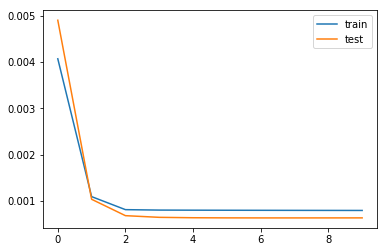

[[0.0244738 ]
 [0.05015232]
 [0.06101431]]
RMSE: 28.195
RMSE: 24.948


In [14]:
train_rmse_lstm1, test_rmse_lstm1 = train_and_evaluate_lstm(train_X1, train_y1, test_X1, test_y1)

### Case2: Train and evaluate the model for sequence prediction using previous 3 hour data


Train on 35040 samples, validate on 8757 samples
Epoch 1/10
 - 5s - loss: 0.0038 - val_loss: 0.0031
Epoch 2/10
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch 3/10
 - 2s - loss: 0.0010 - val_loss: 8.5912e-04
Epoch 4/10
 - 2s - loss: 9.5069e-04 - val_loss: 7.3485e-04
Epoch 5/10
 - 2s - loss: 8.7106e-04 - val_loss: 6.6022e-04
Epoch 6/10
 - 2s - loss: 8.2383e-04 - val_loss: 6.3547e-04
Epoch 7/10
 - 3s - loss: 8.0400e-04 - val_loss: 6.3772e-04
Epoch 8/10
 - 3s - loss: 7.9415e-04 - val_loss: 6.4820e-04
Epoch 9/10
 - 2s - loss: 7.8829e-04 - val_loss: 6.6349e-04
Epoch 10/10
 - 2s - loss: 7.8446e-04 - val_loss: 6.7313e-04


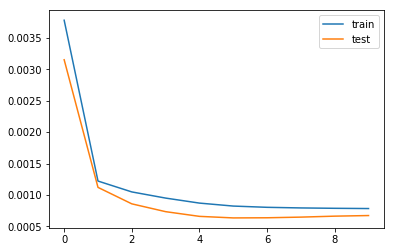

[[0.06230807]
 [0.06659134]
 [0.0872089 ]]
RMSE: 28.618
RMSE: 25.789


In [15]:
train_rmse_lstm3, test_rmse_lstm3 = train_and_evaluate_lstm(train_X2, train_y2, test_X2, test_y2)

## Question:

1. Change the window size that is number of hours you want to use for prediction and  see the change in results

2. Use any other non-linear regression method to get better resultsm, and tabulate

3. Use a sequence prediction method
